In [1]:
import time
from PIL import Image
import numpy as np


In [2]:
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16


Using TensorFlow backend.


In [3]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [4]:
height = 512
width = 512

In [5]:
def get_image(img_path):
    img = Image.open(img_path)
    img = img.resize((height,width))
    return img

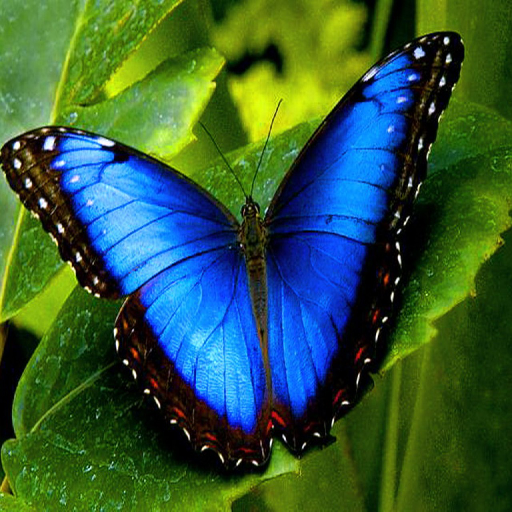

In [6]:
content_image_path = "../../MLData/styles/butterfly-photo.jpg"
content_image = get_image(content_image_path)
content_image

In [7]:
content_image.width

512

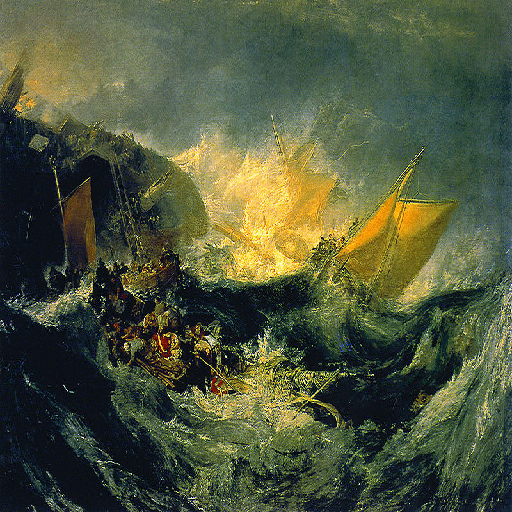

In [15]:
style_image_path = "../../MLData/styles/shipwreck1.jpg"
style_image = get_image(style_image_path)
style_image

In [16]:
content_array = np.asarray(content_image, dtype = "float32")
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype="float32")
style_array = np.expand_dims(style_array,axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [17]:
# subtract mean rgb values as in image net traing set
# flip the ordering from RGB to BGR
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 1] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939 
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [18]:
# Define Tensorflow graph content and images are placed as variables while combintion uses placeholder to store combination image
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [19]:
input_tensor = backend.concatenate([content_image,
                                   style_image,
                                   combination_image], axis=0)

In [20]:
# importing VGG16 model for image classification
model = VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)

In [21]:
layers = dict([(layer.name,layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [22]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [23]:
loss = backend.variable(0.)
# loss function we want to minimise can be decomposed into three distinct parts: the content loss, the style loss and the total variation loss.

In [28]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers["block2_conv2"]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                     combination_features)

In [31]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S-C))/(4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name